## Importing libraries & Reading files

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import math
import matplotlib.pyplot as plt
import datetime
from datetime import date
from tqdm.notebook import tqdm
print("Libraries Imported")

#path of fundamental data file
f_path = r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\CSV\All Fundamental Data.csv"

#path of closing prices file 
c_path  = r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\CSV\All Close Prices.csv"

#reading files
fdf = pd.read_csv(f_path, encoding='windows-1252')
cdf = pd.read_csv(c_path, encoding='windows-1252')

print("file reading done.")
#fdf.drop(columns=['Unnamed: 0'],inplace=True)
#cdf.drop(columns=['Unnamed: 0'],inplace=True)

Libraries Imported
file reading done.


# Input Variables
Enter your Input varibales here, in the given format

In [438]:
start_year = 2005           # Format : YYYY

buy_date   = '2023-07-01'   # Format : YYYY-MM-DD
sell_date  = '2024-07-01'   # Format : YYYY-MM-DD

indicator  = "ROCE"         # Format : "ROCE" or "ROE"

m = 0                       # Top companies Ranking from m
n = 30                      # Top companies Ranking till n
                            # Get top m to n companies;    here get Top 0-30 companies

transaction_cost = 0.1      # Percentage of Transaction cost eg.input 1 if you want 1% ; here 0.1 => 0.1%
capital = 1000000           # Capital in the beginning of the backtest


### Getting data from inputs
No output for this code, just some minor calculations.

In [439]:
initial_capital   = capital

buy_date = pd.to_datetime(buy_date)
sell_date = pd.to_datetime(sell_date)

buy_str  = f"-{buy_date.month}-{buy_date.day}"
sell_str = f"-{sell_date.month}-{sell_date.day}"

# Getting End Year date

if buy_date.month > 3:
    end_year = buy_date.year - 2
else :
    end_year = buy_date.year - 3
    
end_year

2021

----

## TRADE SHEET GENERATION CODE
Run this code to get the Trade Sheet

In [440]:
# Blank Dataframe to store Yearly Tradesheet
change = pd.DataFrame()

for year in tqdm(range(start_year, end_year+1)):
    
    f1 = fdf[fdf['Year']==year]
    
    # Fundamental Conditions
    conditions = ["Shareholder's Funds", "PAT", "PBIT"]
    
    for condition in conditions:
        f1 = f1[f1.fillna(0)[condition] > 0]
    
    # Market Cap Condition
    f1 = f1[(f1['Market Cap']>=500) & (f1['Market Cap']<=20000)]
    
    cdf['Date'] = pd.to_datetime(cdf['Date'])
    cdf['Year'] = cdf['Date'].dt.year
    
    # Indicator Conditions
    if indicator == "ROCE" :
        
        # Remove Banking stocks in ROCE
        f1 = f1[~f1['Name'].str.contains('Bank')]
        
        # ROCE Formula
        f1[indicator] = (f1['Adj PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Total Debt"].fillna(0)))*100
        #f1[indicator] = (f1['Adj PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Long Term Borrowings"].fillna(0) + f1["Short Term Borrowings"].fillna(0)))*100

    elif indicator == "ROE" :
        
        # ROE Formula
        f1[indicator] = (f1['Adj PAT'].fillna(0) / f1["Shareholder's Funds"].fillna(0))*100
        
        
    # New dataframe to store calculations 
    f2 = f1[['Name',indicator]]                                                            # Name, Indicator
    f2['Buy Date'] = date(year+1,buy_date.month,buy_date.day)                                                        # Buy Date
    
    # Dataframe of companies containing closings on 1st July of start year & next year
    cnam  = cdf[cdf['Date'] == f'{year+1}{buy_str}']
    cnam2 = cdf[cdf['Date'] == f'{year+2}{sell_str}']
    
    
    # Reset Indexes
    f2.reset_index(drop=True,inplace=True)
    cnam.reset_index(drop=True,inplace=True)
    
    
    # Adding Closing Prices of Start year (Buying Price) and dropping companies with no Closing prices 
    f2 = pd.merge(f2,cnam[['Name','Close']], how='left',on='Name').dropna()
    f2.rename(columns={'Close':'Close1'},inplace=True)
    
    # SORTING VALUES BY INDICATOR
    f2 = f2.sort_values(by=[indicator], ascending=False)
    
    f2.reset_index(drop=True,inplace=True)                                                 # Reset Indexes
    
    # Adding Selling Date
    f2['Sell Date'] = date(year+2,sell_date.month,sell_date.day)
    
    # Adding Closing Prices of Next year (Selling Price) and dropping companies with no Closing prices 
    f2 = pd.merge(f2,cnam2[['Name','Close']], how='left',on='Name')
    f2.rename(columns={'Close':'Close2'},inplace=True)                                     # Reset Indexes
    
    # New Dataframe to store Top n Companies and Find Quantity
    f3 = f2[m:n]
    
    #display(f3)
    
    # Filling companies with no Selling Prices with last present close and update the Selling Dates
    for i in range(f3.shape[0]):
        if f3.fillna(0)['Close2'].iloc[i] == 0 :
            f3['Close2'].iloc[i]    = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')].sort_values(by="Date", ascending=False)['Close'].iloc[0]
            f3['Sell Date'].iloc[i] = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')].sort_values(by="Date", ascending=False)['Date'].iloc[0].date()
    
    #display(f3)
    
    # Claculating Quantity
    f3['Qty'] = capital/((n-m)*f3['Close1'])
    
    # Defining a function for Roundown
    def Floor(x):
        try:
            return math.floor(x)
        except:
            return(x)
    
    # Rounddown Quantity
    f3['Qty'] = f3['Qty'].apply(Floor)
    
    # Buying & Selling Value = Qty x Close Price
    f3['Buy Value'] = f3['Qty']*f3['Close1']
    f3['Sell Value'] = f3['Qty']*f3['Close2']
    
    f3['% Change'] = (f3['Close2'] / f3['Close1'] - 1)*100
    
    f3['Transaction Cost'] = (transaction_cost / 100)*(f3['Buy Value']+f3['Sell Value'])
    
    #print(f"{year} Starting Capital is {capital}")
    
    capital = f3['Sell Value'].sum() - f3['Transaction Cost'].sum()
    
    #print(f"{year} Ending Capital is {capital}")
    
    change = change.append(f3)
    
display(change)    

path_to = fr"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\Outputs\{start_year}-{str(end_year)[-2:]}-{indicator}-Backtest-{initial_capital}-{buy_date.date()}-{sell_date.date()}-{m}-{n}-{transaction_cost}-Reports{datetime.datetime.now()}.xlsx"

change.to_excel(path_to,sheet_name="Trade Sheet")

cagr        = ((capital/initial_capital)**(1/(end_year-start_year+1))-1)*100
print(cagr)

  0%|          | 0/17 [00:00<?, ?it/s]

,Name,ROCE,Buy Date,Close1,Sell Date,Close2,Qty,Buy Value,Sell Value,% Change,Transaction Cost
0,Nestle India Ltd.,127.367387,2006-07-01,996.150000,2007-07-01,1159.950000,33,32872.950000,38278.350000,16.443307,71.151300
1,Praj Industries Ltd.,62.151226,2006-07-01,101.200000,2007-07-01,237.500000,329,33294.800000,78137.500000,134.683794,111.432300
2,Dabur India Ltd.,45.396316,2006-07-01,47.283333,2007-03-31,47.283333,704,33287.466667,33287.466667,0.000000,66.574933
3,Bharat Electronics Ltd.,42.581909,2006-07-01,10.818182,2007-07-01,18.495960,3081,33330.818182,56986.051515,70.971055,90.316870
4,Asian Paints Ltd.,39.058587,2006-07-01,57.515000,2007-03-31,57.515000,579,33301.185000,33301.185000,0.000000,66.602370
...,...,...,...,...,...,...,...,...,...,...,...
25,Anand Rathi Wealth Ltd.,46.034162,2022-07-01,652.700000,2023-05-10,870.700000,486,317212.200000,423160.200000,33.399724,740.372400
26,Sonata Software Ltd.,45.586528,2022-07-01,496.762500,2023-05-10,851.750000,638,316934.475000,543416.500000,71.460205,860.350975
27,Godawari Power And Ispat Ltd.,45.180094,2022-07-01,254.000000,2023-05-10,373.150000,1249,317246.000000,466064.350000,46.909449,783.310350
28,Universus Photo Imagings Ltd.,44.979736,2022-07-01,514.100000,2023-05-10,412.150000,617,317199.700000,254296.550000,-19.830772,571.496250


15.126369830344899


----

## REPORTS GENERATION CODE
Run this code to get the Trade Reports


TOP WINNERS


,Name,Buy Date,% Change
0,IIFL Finance Ltd.,2006-07-01,556.787851
1,Alkyl Amines Chemicals Ltd.,2020-07-01,327.409117
2,Deepak Nitrite Ltd.,2020-07-01,293.180157
3,Tanfac Industries Ltd.,2022-07-01,241.671931
4,TTK Prestige Ltd.,2010-07-01,240.379754
5,Symphony Ltd.,2013-07-01,231.245006
6,Indiamart Intermesh Ltd.,2020-07-01,223.082839
7,Sonata Software Ltd.,2020-07-01,216.624738
8,LS Industries Ltd.,2012-07-01,202.103250
9,Coforge Ltd.,2006-07-01,193.879875



TOP LOSERS


,Name,Buy Date,% Change
0,Capri Global Capital Ltd.,2010-07-01,-88.857609
1,Spectacle Ventures Ltd.,2010-07-01,-87.167806
2,Securekloud Technologies Ltd.,2018-07-01,-82.825089
3,Stampede Capital Ltd.,2016-07-01,-80.411499
4,Suumaya Industries Ltd.,2021-07-01,-78.824268
5,EKI Energy Services Ltd.,2022-07-01,-75.896348
6,Vakrangee Ltd.,2017-07-01,-68.964717
7,Coforge Ltd.,2007-07-01,-66.074196
8,MIC Electronics Ltd.,2008-07-01,-65.945437
9,Paul Merchants Ltd.,2018-07-01,-65.376787


  0%|          | 0/17 [00:00<?, ?it/s]


Daily Portfolio Value


,Date,PV
0,2023-06-30 00:00:00,10984549.93
1,2023-06-29 00:00:00,10984549.93
2,2023-06-28 00:00:00,10984549.93
3,2023-06-27 00:00:00,10984549.93
4,2023-06-26 00:00:00,10984549.93
...,...,...
360,2006-07-05 00:00:00,995381.409953
361,2006-07-04 00:00:00,989445.37481
362,2006-07-03 00:00:00,996410.896623
363,2006-07-02 00:00:00,998370.083316


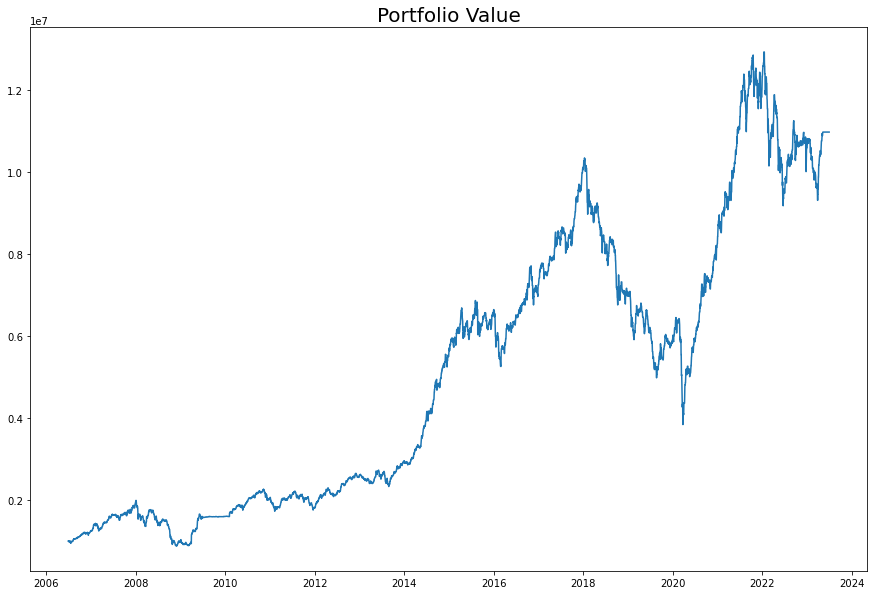

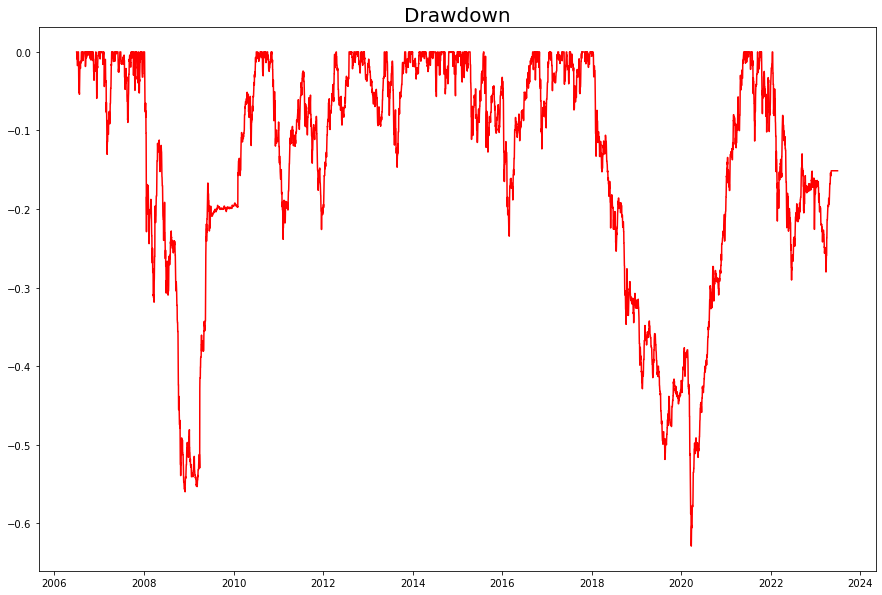

,CAGR,Trading Edge,MDD,CAR/MDD
0,15.12637,19.351056,-62.880826,0.240556


In [441]:
#display(change)

# TOP n Winners & Losers

winners = change[change['% Change']>0].sort_values(by="% Change", ascending=False)[['Name','Buy Date','% Change']]
losers  = change[change['% Change']<0].sort_values(by="% Change", ascending=True )[['Name','Buy Date','% Change']]
winners.reset_index(drop=True, inplace=True)
losers.reset_index(drop=True, inplace=True)


winners_counts = change[change['% Change']>0].shape[0] / change.shape[0]
losers_counts  = change[change['% Change']<0].shape[0] / change.shape[0]

avg_win  = change[change['% Change']>0]['% Change'].mean()
avg_loss = change[change['% Change']<0]['% Change'].mean()


print("\nTOP WINNERS")
display(winners[:10])

print("\nTOP LOSERS")
display(losers[:10])




# Finding Daily Portfolio Value

k = 0

combined_PV = pd.DataFrame(columns=['Date','PV'])

for year in tqdm(range(start_year,end_year+1)):
    
    #print(year)
    multipv = pd.DataFrame(columns=['Date','PV'])
    multipv['Date'] = pd.date_range(date(year+1,buy_date.month,buy_date.day) ,date(year+2,sell_date.month,sell_date.day)-datetime.timedelta(1)).sort_values(ascending=False)
    multipv['PV'].fillna(0,inplace=True)
    
    for i in range(k,(n-m)+k):

        pv1 = cdf[(cdf['Name']==change['Name'].iloc[i]) & (cdf['Date'] >= f'{year+1}{buy_str}') & (cdf['Date'] < f'{year+2}{sell_str}')]

        pv1 = pv1[['Name','Date','Close']]
        pv1.reset_index(drop=True, inplace = True)

        all_dates = pd.DataFrame(columns=['Name','Date','Close'])
        all_dates['Date'] = pd.date_range(date(year+1,buy_date.month,buy_date.day) ,date(year+2,sell_date.month,sell_date.day)-datetime.timedelta(1)).sort_values(ascending=False)
        
        
        
        for j in range(all_dates.shape[0]):
            if all_dates['Date'].iloc[j] not in pv1['Date'].tolist():
                pv1 = pv1.append(all_dates.iloc[j])
        
        
        pv1.sort_values(by='Date', ascending=False, inplace=True) 
        pv1.reset_index(drop=True, inplace = True)
        
        pv1 = pv1[['Name','Date','Close']].bfill().ffill()
        pv1.reset_index(drop=True, inplace = True)
        
        pv1['PV'] = pv1['Close']*change['Qty'].iloc[i]
        pv1['Date'] = pd.to_datetime(pv1['Date'])
        
#         display(pv1)
#         display(multipv)
        
        multipv['PV'] = np.where(multipv['Date'] == pv1['Date'], multipv['PV']+pv1['PV'], np.nan)

    combined_PV = multipv.append(combined_PV)
    k += (n-m)

print("\nDaily Portfolio Value")
display(combined_PV)

print()



combined_PV = combined_PV.sort_values(by='Date', ascending=True)
combined_PV['MDD'] = (combined_PV['PV']/combined_PV['PV'].rolling(len(combined_PV),1).max())-1
combined_PV = combined_PV.sort_values(by='Date',ascending=False)
combined_PV.reset_index(drop=True,inplace=True)



plt.figure(figsize=(15,10))
plt.plot(combined_PV["Date"],combined_PV["PV"])
plt.title("Portfolio Value", fontsize=20)
plt.show()

plt.figure(figsize=(15,10))
plt.plot(combined_PV["Date"],combined_PV["MDD"],color = 'red')
plt.title("Drawdown", fontsize=20)
plt.show()


# Ratios

tradingedge = winners_counts*avg_win + losers_counts*avg_loss

cagr        = ((capital/initial_capital)**(1/(end_year-start_year+1))-1)*100

mdd         = min(combined_PV['MDD'])*100

calc = pd.DataFrame({"CAGR":[cagr],  "Trading Edge":[tradingedge], "MDD":[mdd], "CAR/MDD":[-cagr/mdd]})

display(calc)

___________

## Monthly Table

In [442]:
# Monthly Table

monthlydf = combined_PV.copy()
monthlydf['Date']  = pd.to_datetime(monthlydf['Date'])
monthlydf['Month'] = monthlydf['Date'].dt.month
monthlydf['Year']  = monthlydf['Date'].dt.year


monthlydf = monthlydf.drop_duplicates(subset=['Month','Year'])[['Month','Year','PV']].reset_index(drop=True)
monthlydf['% Change'] = np.nan

yearlydf = monthlydf.drop_duplicates(subset=['Year']).sort_values(by='Year',ascending=False).reset_index(drop=True)
yearlydf['% Change'] = np.nan


for i in range(monthlydf.shape[0]):
    try:
        monthlydf['% Change'].iloc[i] = (monthlydf['PV'].iloc[i]/monthlydf['PV'].iloc[i+1] - 1)*100
    except:
        continue

        
for i in range(yearlydf.shape[0]):
    try:
        y = monthlydf[monthlydf['Year']==yearlydf['Year'].iloc[i]]
        yearlydf['% Change'].iloc[i] = (y['PV'].iloc[0]/y['PV'].iloc[-1] - 1)*100
        
        #yearlydf['% Change'].iloc[i] = (yearlydf['PV'].iloc[i]/yearlydf['PV'].iloc[i+1] - 1)*100
        
    except:
        continue
        
        

monthly_years = monthlydf['Year'].unique().tolist()
monthly_years = ['Months']+monthly_years


monthly_matrix = pd.DataFrame(columns=monthly_years)
monthly_matrix['Months'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']


for i in range(monthly_matrix.shape[0]):
    for j in monthlydf['Year'].unique().tolist():
        try:
            monthly_matrix[j].iloc[i] = monthlydf[(monthlydf['Month']==i+1) & (monthlydf['Year']==j)]['% Change'].iloc[0]
        except:
            continue
            
#display(yearlydf)            

monthly_matrix = monthly_matrix.T
monthly_matrix.columns = monthly_matrix.iloc[0]
monthly_matrix.drop('Months', inplace=True)

monthly_matrix['Months']=monthly_matrix.index
monthly_matrix['Total'] = np.nan

for i in range(monthly_matrix.shape[0]):
    monthly_matrix['Total'].iloc[i] = yearlydf[yearlydf['Year']==monthly_matrix['Months'].iloc[i]]['% Change'].iloc[0]

monthly_matrix.columns.name = ''
monthly_matrix.reset_index(drop=True, inplace=True)
monthly_matrix = monthly_matrix[['Months','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','Total']]


display(monthly_matrix)




,Months,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec,Total
0,2023,0.032224,-7.518935,-2.257002,12.306432,1.979241,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.527299
1,2022,-2.129588,-10.938777,1.183819,4.252307,-10.147381,-6.821638,8.366134,1.970261,0.332715,1.011041,1.679917,-1.971137,-12.199118
2,2021,2.722706,6.344387,2.4595,7.517877,5.407607,6.087853,8.574511,-3.033502,4.205895,-1.193735,-3.007304,5.087943,44.744939
3,2020,5.345624,-4.736797,-30.365685,27.196055,0.315724,11.01038,8.524693,9.488405,4.641536,-0.713293,8.016241,6.136129,32.983861
4,2019,-9.037853,-3.590533,6.47634,-1.734162,2.246562,-6.233357,-14.669831,-1.881492,7.313317,7.22438,-1.815857,0.838637,-7.755291
5,2018,-4.367547,-4.665431,-4.430815,3.993511,-6.785563,-4.775261,0.559738,1.735519,-13.738283,-1.456218,0.166349,-0.440286,-27.061461
6,2017,6.20806,-1.785292,3.755547,0.746626,4.743813,1.225884,1.67919,-2.182649,-0.707549,11.12532,5.395623,4.377987,31.415638
7,2016,-9.131278,-12.485565,8.703551,7.739924,0.818376,4.961989,2.129388,2.560898,2.483176,9.245395,-6.194523,1.136085,20.668644
8,2015,5.055202,0.266871,5.410102,-2.152873,5.334965,-3.385943,8.312812,-4.825587,-0.176371,1.607783,-1.028263,3.763903,13.010426
9,2014,-2.483129,4.588385,7.644301,1.557342,8.342401,11.789872,3.985551,7.287938,8.768488,5.460086,5.230144,3.818687,93.605436


## Comparison with Indexes ⬇
Comparing the returns with :
* Nifty 50
* Nifty Midcap 100
* BSE500

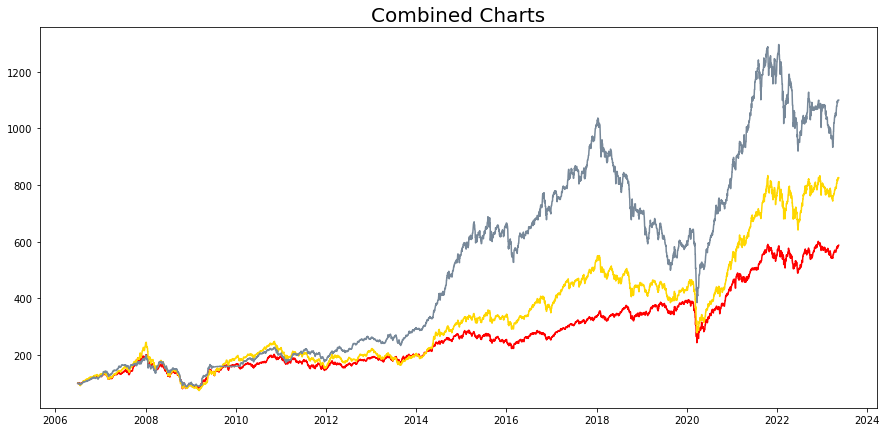

Nifty50        : RED 
NiftyMidcap100 : YELLOW 
BSE500         : BLUE 
QGF            : GREY


,Index,CAGR
0,Nifty50,10.978606
1,NiftyMidcap100,13.224708
2,BSE500,7.699995
3,QGF,15.126370


,Date,Nifty50,NiftyMidcap100,BSE500,QGF
0,2023-05-15,587.580717,826.039066,inf,1100.248306
1,2023-05-14,585.474075,823.100909,inf,1100.248306
2,2023-05-13,585.474075,823.100909,inf,1100.248306
3,2023-05-12,585.474075,823.100909,inf,1100.248306
4,2023-05-11,584.905057,826.468761,inf,1100.248306
...,...,...,...,...,...
6158,2006-07-05,102.202545,100.960795,NaN,99.700645
6159,2006-07-04,100.334058,99.889724,NaN,99.106072
6160,2006-07-03,100.727255,100.145767,NaN,99.803761
6161,2006-07-02,100.000000,100.000000,NaN,100.0


In [469]:
# Comparison with Indexes


indexes = ['Nifty50','NiftyMidcap100','BSE500']

comparisons = pd.DataFrame({'Index':['Nifty50', 'NiftyMidcap100', 'BSE500','QGF']})
comparisons['CAGR'] = np.nan

combined_ind = pd.DataFrame()
# combined_ind['Date'] = pd.date_range(date(start_year,buy_date.month,buy_date.day) ,date(buy_date.year,buy_date.month,buy_date.day)-datetime.timedelta(1)).sort_values(ascending=False)


for index in indexes:
    idf  = pd.read_excel(r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\CSV\Indexes Daily Closing.xlsx", sheet_name=index)
    idf['Date'] = pd.to_datetime(idf['Date'])
    
    idf2 = idf[(idf['Date'] >= str(start_year+1)+buy_str) & (idf['Date'] <= str((date(buy_date.year,buy_date.month,buy_date.day)-datetime.timedelta(1))))]
    idf2['Date'] = pd.to_datetime(idf2['Date'])
    #display(idf2)
    
    combined_ind['Date'] = idf2['Date']
    combined_ind[index] = idf2['Close']
    
    for i in range(comparisons.shape[0]):
        if comparisons['Index'].iloc[i] == index:
            comparisons['CAGR'].iloc[i] = ((idf2['Close'].iloc[0]/idf2[idf2['Close']!=0]['Close'].iloc[-1])**(1/(end_year-start_year+1))-1)*100
            
        elif comparisons['Index'].iloc[i] == 'QGF':
            comparisons['CAGR'].iloc[i] = cagr
    
pv = combined_PV[(combined_PV['Date'] >= combined_ind['Date'].iloc[-1]) & (combined_PV['Date'] <= combined_ind['Date'].iloc[0])]
#display(pv)

pv.reset_index(drop=True,inplace=True)

combined_ind['QGF'] = pv['PV']

for column in combined_ind.columns:
    if column == 'Date':
        continue
    else:
        combined_ind[column] = (combined_ind[column]  / combined_ind[column].iloc[-1])*100

#combined_ind['QGF'] = pv['PV']

plt.figure(figsize=(15,7))
plt.plot(combined_ind["Date"],combined_ind["Nifty50"], color = "red")
plt.plot(combined_ind["Date"],combined_ind["NiftyMidcap100"], color = "gold")
plt.plot(combined_ind["Date"],combined_ind["BSE500"],"dodgerblue")
plt.plot(combined_ind['Date'], combined_ind['QGF'],color="lightslategrey")
plt.title("Combined Charts", fontsize=20)
plt.show()

print("Nifty50        : RED \nNiftyMidcap100 : YELLOW \nBSE500         : BLUE \nQGF            : GREY")
    
    
display(comparisons)

display(combined_ind)


---------

## Save the Output files
Run this Code to save all the Output Reports & files you get.

In [470]:
with pd.ExcelWriter(path_to,engine='openpyxl', mode='a',if_sheet_exists='replace') as writer :
    combined_PV.to_excel(writer,sheet_name="Daily Portfolio Value",index=False)
    winners.to_excel(writer,sheet_name="Winners",index=False)
    losers.to_excel(writer,sheet_name="Losers",index=False)
    calc.to_excel(writer,sheet_name="Calculations",index=False)
    monthly_matrix.to_excel(writer,sheet_name="Monthly Table",index=False)
    combined_ind.to_excel(writer,sheet_name="Daily Index Prices",index=False)
    comparisons.to_excel(writer,sheet_name="Index Comparisons",index=False)

___________

## Output Variable names
* change : Tradelist
* combined_PV : Daily Portfolio Value
* winners : All Winners in descending
* losers : All Losers in ascending
* cagr : CAGR
* tradingedge : Trading Edge
* mdd : Max Drawdown
* monthly_matrix : Monthly Table
* comparisons : QGF vs Indexes change
* combined_ind : Daily Index Prices for given range

___________